<a href="https://colab.research.google.com/github/Apex95/tesseract-preprocessing-convolution-poc/blob/master/Sprint_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt install tesseract-ocr
!pip3 install python-Levenshtein
!pip3 install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [0]:
from PIL import Image
import math
import numpy as np
import torch
import torch.utils.data as data_utils

## Dataset Loader

# adds image border in order to fit in a tensor
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

images = []

targets_indices = []

batch_size = 5

for i in range(5):

  img = Image.open(str(i+1) + '.jpg')
  img = add_margin(img, math.floor((59-img.size[1]) / 2), math.floor((1357-img.size[0]) / 2), math.ceil((59-img.size[1]) / 2), math.ceil((1357-img.size[0]) / 2), (255, 255, 255)).convert("RGB")

  img = np.array(img)

  images.append(img)

  targets_indices.append(i)


train_data = data_utils.TensorDataset(torch.Tensor(images).permute(0, 3, 1, 2), torch.Tensor(targets_indices))

use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True, **kwargs)



In [0]:
## Convolution Utils

def convolve(input):
  
    n_of_kernels = 2
    kernels = []

    # hardcoded kernels, generated using unsupervised learning
    kernels.append(torch.tensor(
        [[[[-0.0990, -0.0997,  0.0955],
          [-0.0998,  1.0959,  0.0985],
          [ 0.0974,  0.1000,  0.0997]]],


        [[[ 0.1000,  0.1000, -0.1000],
          [-0.0985,  0.9000,  0.0990],
          [-0.0989,  0.0988,  0.0525]]],


        [[[ 0.1000,  0.1000, -0.0988],
          [ 0.0866,  0.9000,  0.1000],
          [ 0.1000,  0.1000, -0.0990]]]]))
    
    kernels.append(torch.tensor(
        [[[[-0.0994,  0.0982,  0.1000],
          [ 0.1000,  0.9004, -0.0988],
          [ 0.1000, -0.0995, -0.0971]]],


        [[[-0.0986,  0.0995,  0.0981],
          [-0.1000,  0.9001,  0.0988],
          [ 0.0927, -0.0994,  0.1000]]],


        [[[-0.0992,  0.1000,  0.1000],
          [ 0.1000,  0.9000,  0.0997],
          [ 0.1000,  0.1000,  0.0998]]]]))

    output = input

    # convolve
    for i in range(n_of_kernels):
        output = torch.nn.functional.conv2d(output, kernels[i], bias=None, padding=1, stride=1, groups=n_of_channels) #.to(device)
        output = torch.nn.functional.relu(output)

    batch_of_images = output.permute(0,2,3,1) # * 255
    batch_of_images = torch.clamp(batch_of_images, 0, 255).type(torch.uint8).cpu().numpy()

    return batch_of_images

In [0]:
## Score Utils

import pytesseract
n_of_channels = 3

def run_through_tesseract(img):
  
  img = Image.fromarray(img.squeeze(), 'L' if n_of_channels == 1 else 'RGB')
  tess_output = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)


  recognized_text = ' '.join(s for s in tess_output["text"] if len(s) > 0) 
  
  return recognized_text


def compute_score(img, expected_text):

  recognized_text = run_through_tesseract(img)

  return -Levenshtein.distance(recognized_text, expected_text)

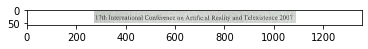

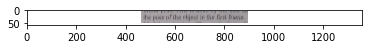

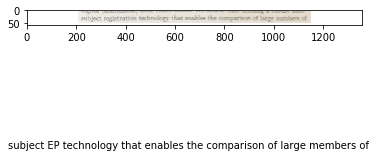

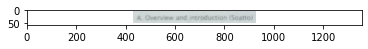

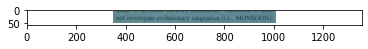

In [0]:
## Running Tesseract on Inputs

import matplotlib.pyplot as pyplot


for batch_id, (input, target) in enumerate(train_loader):
  input = input.permute(0, 2, 3, 1)
  input = torch.clamp(input, 0, 255).type(torch.uint8).numpy()

  for i in range(batch_size):
    recognized_text = run_through_tesseract(input[i])
    
    fig = pyplot.figure()
    fig.text(.5, .05, recognized_text, ha='center')
    pyplot.imshow(input[i])




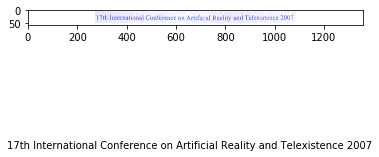

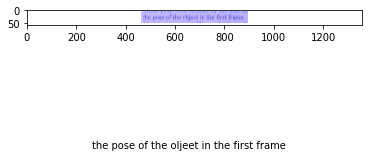

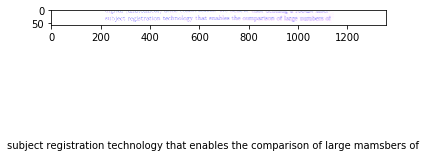

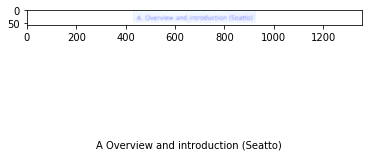

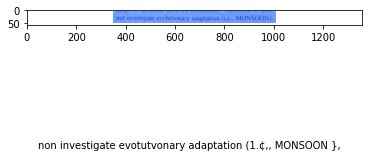

In [0]:
## Running Tesseract after Conv Preprocessing

for batch_id, (input, target) in enumerate(train_loader):

  # convolves with hardcoded kernels; also performs shape permutations
  conv_result = convolve(input)

  for i in range(batch_size):
    recognized_text = run_through_tesseract(conv_result[i])
      
    fig = pyplot.figure()
    fig.text(.5, .05, recognized_text, ha='center')
    
    Image.fromarray(conv_result[i]).save(str(i + 1) + "_conv.jpg")
    pyplot.imshow(conv_result[i])
    #pyplot.savefig(str(i + 1) + "_conv.jpg")

